In [1]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from PIL import Image
import numpy as np 
import matplotlib.pyplot as plt 
import os
import shutil

Using TensorFlow backend.
/home/taher/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/taher/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/taher/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/taher/.local/lib/python3.6/site-packages/tensorflow/python/fra

In [2]:
# define the test configuration
class TestConfig(Config):
    NAME = "test"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 80

In [3]:
# define model.
rcnn=MaskRCNN(mode='inference',model_dir='./',config=TestConfig())



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [4]:
#load coco model weights
rcnn.load_weights('mask_rcnn_coco.h5', by_name=True)

In [6]:
# define 81 classes that the coco model knowns about
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

<font color='black'> **An overview of which could do our alghoritm.**</font>

In [7]:
# load an exemple photo.
img=load_img('n02085620_7.jpg')
img=img_to_array(img )

In [8]:
#make prediction
result=rcnn.detect([img],verbose=0)

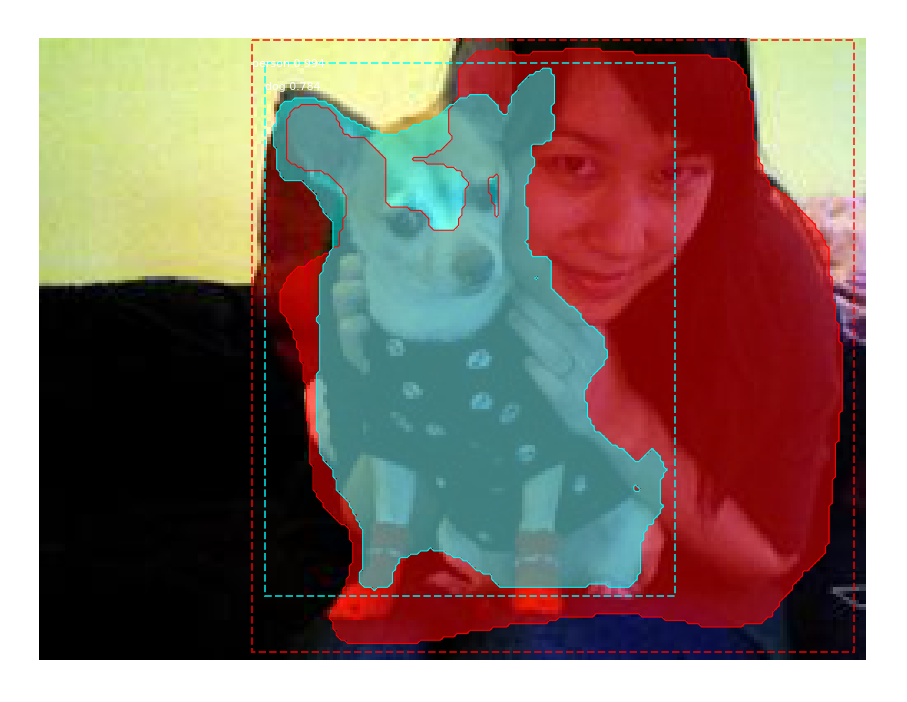

In [9]:
#show photo with bounding boxes, masks, class labels and scores.
from mrcnn.visualize import display_instances
r=result[0]
display_instances(img,r['rois'],r['masks'],r['class_ids'],class_names,r['scores'])

# Implementation of Mask Rcnn in our dataset

Hereunder, we will create function , which allow to automatise the following operations in each photo:  
      -loading photo.  
      -Apply Mask Rcnn.   
      -Extracte the coordinates of the bounding box arounding the dog photo.  
      -Create, new image correpond only to the bounding box arounding the dog.

In [10]:
def detect_dog(photo):
    ''' This function, will detect the localization of the dog in each photo if it is exist.Then it will
        create new image with  pixels, which  belong to bounding box arounding the dog.
        
        Args:
        
        photo(string): the file name of the photo, that the function will transformate.
        
        
        Returns:
        
        photo(Image): The returned photo 
    '''
    img=load_img(photo,target_size=(224,224)) # loading the photo.
    img=img_to_array(img)
    result=rcnn.detect([img],verbose=0)         # Apply the rcnn model to our photo.
    r=result[0]                               # dictionnary of the detection results.
    objets=r['class_ids']                     # the class key for the detected objects.
    l=len(objets)
    j=0
    for i in range(l):
        if objets[i] == 17:                    # 17 is the key of the dog class.
           break
        j+=1
    im=img                   #create a numpy array full in zero with the dimension of the introduced photo.
    if j in range(l):
       y1,x1,y2,x2=r['rois'][j]                 # get coordinates
       im=np.zeros((y2-y1,x2-x1,3))
       for i in range(y1,y2):
          for j in range(x1,x2):
              for k in range(1,3):
                  i1=i-y1
                  j1=j-x1
                  im[i1,j1,k]=img[i,j,k]
    iml=Image.fromarray(im.astype('uint8'))
    return iml

In [11]:
#Implementing of our function to our image example.
img=detect_dog('n02085620_7.jpg')

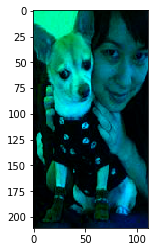

In [12]:
#Preview of the result of our function.
plt.imshow(img)

<font color=blue><font size=4>** Prepare training datas ** </font>

In [2]:
path=os.path.abspath(os.path.dirname('__file__')) 

In [14]:
path_tr=os.path.join(path,'train') # The path of the training datas.

In [15]:
ms_tr='{}/{}'.format(path,'tr_train')
if os.path.exists(ms_tr):
    shutil.rmtree(ms_tr)
os.mkdir(ms_tr)

In [16]:
for fil in os.listdir(path_tr):
    dos='{}/{}'.format(path_tr,fil)
    des='{}/{}'.format(ms_tr,fil)
    if os.path.exists(des):
        shutil.rmtree(des)
    os.mkdir(des)
    for image in os.listdir(dos):
        img=os.path.join(dos,image)
        im=detect_dog(img)
        im.save('{}/{}'.format(des,image))

<font color=blue><font size=4>Prepare test datas</font>

In [17]:
path_ts=os.path.join(path,'test') # The path of the test datas.

In [18]:
ms_ts='{}/{}'.format(path,'tr_test')
if os.path.exists(ms_ts):
    shutil.rmtree(ms_ts)
os.mkdir(ms_ts)

In [19]:
for fil in os.listdir(path_ts):
    dos='{}/{}'.format(path_ts,fil)
    des='{}/{}'.format(ms_ts,fil)
    if os.path.exists(des):
        shutil.rmtree(des)
    os.mkdir(des)
    for image in os.listdir(dos):
        img=os.path.join(dos,image)
        im=detect_dog(img)
        im.save('{}/{}'.format(des,image))

# Data augmentation

In [3]:
from keras.preprocessing.image import ImageDataGenerator
batch_size=16
#prepare data augmentation generation
train_datagen=ImageDataGenerator(rescale=1/255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1/255)

In [4]:
ms_tr='{}/{}'.format(path,'tr_train')
ms_ts='{}/{}'.format(path,'tr_test')
#training data aufmentation 
train_generator=train_datagen.flow_from_directory(ms_tr,target_size=(224,224),batch_size=batch_size,\
                                                 class_mode='categorical')
#test data augmentation
test_generator=test_datagen.flow_from_directory(ms_ts,target_size=(224,224),batch_size=batch_size,\
                                                 class_mode='categorical')

Found 14458 images belonging to 120 classes.
Found 6122 images belonging to 120 classes.


# CNN Aproach

In [5]:
from keras.applications import VGG16
from keras.layers import Dense,Flatten,GlobalAveragePooling2D,Dropout,Conv2D,MaxPool2D
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import optimizers

In [6]:
# import VGG16 architecture without fully connected layers.
model=VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))
x1=model.output    # recuperate the output of our model.
#Add new fully connected layers to determinate dog's breed.
x1=Flatten()(x1)
y1=Dense(210,activation='relu')(x1)
y1=Dense(200,activation='relu')(y1)
prediction=Dense(120,activation='softmax')(y1)
#Define the new model
new_model=Model(inputs=model.input,outputs=prediction)

In [7]:
#save the weight of the fifth first layers and retrain the rest of the other layers.
for layer in model.layers[:5]:
    layer.trainable=False

In [8]:
new_model.compile(loss='categorical_crossentropy',optimizer=optimizers.SGD(lr=0.001,momentum=0.9),metrics=['accuracy'])

In [9]:
new_model.fit_generator(train_generator,steps_per_epoch=batch_size,epochs=600,validation_data=test_generator\
                       ,validation_steps=batch_size,verbose=2)


Epoch 1/600
 - 258s - loss: 4.8518 - accuracy: 0.0078 - val_loss: 4.9670 - val_accuracy: 0.0039
Epoch 2/600
 - 245s - loss: 4.8468 - accuracy: 0.0000e+00 - val_loss: 4.8160 - val_accuracy: 0.0078
Epoch 3/600
 - 251s - loss: 4.7903 - accuracy: 0.0080 - val_loss: 4.8034 - val_accuracy: 0.0039
Epoch 4/600
 - 236s - loss: 4.7823 - accuracy: 0.0078 - val_loss: 4.7943 - val_accuracy: 0.0039
Epoch 5/600
 - 241s - loss: 4.7853 - accuracy: 0.0078 - val_loss: 4.7965 - val_accuracy: 0.0039
Epoch 6/600
 - 262s - loss: 4.7958 - accuracy: 0.0039 - val_loss: 4.7651 - val_accuracy: 0.0000e+00
Epoch 7/600
 - 271s - loss: 4.7976 - accuracy: 0.0156 - val_loss: 4.7847 - val_accuracy: 0.0156
Epoch 8/600
 - 252s - loss: 4.7863 - accuracy: 0.0195 - val_loss: 4.7927 - val_accuracy: 0.0117
Epoch 9/600
 - 232s - loss: 4.7848 - accuracy: 0.0039 - val_loss: 4.7932 - val_accuracy: 0.0078
Epoch 10/600
 - 226s - loss: 4.7884 - accuracy: 0.0156 - val_loss: 4.7896 - val_accuracy: 0.0078
Epoch 11/600
 - 223s - loss: 4

 - 229s - loss: 4.7850 - accuracy: 0.0078 - val_loss: 4.7874 - val_accuracy: 0.0117
Epoch 84/600
 - 223s - loss: 4.7833 - accuracy: 0.0078 - val_loss: 4.7791 - val_accuracy: 0.0117
Epoch 85/600
 - 223s - loss: 4.7844 - accuracy: 0.0000e+00 - val_loss: 4.7995 - val_accuracy: 0.0156
Epoch 86/600
 - 223s - loss: 4.7826 - accuracy: 0.0195 - val_loss: 4.7287 - val_accuracy: 0.0156
Epoch 87/600
 - 229s - loss: 4.7828 - accuracy: 0.0078 - val_loss: 4.8146 - val_accuracy: 0.0000e+00
Epoch 88/600
 - 224s - loss: 4.7775 - accuracy: 0.0234 - val_loss: 4.8057 - val_accuracy: 0.0078
Epoch 89/600
 - 223s - loss: 4.7772 - accuracy: 0.0117 - val_loss: 4.8753 - val_accuracy: 0.0039
Epoch 90/600
 - 224s - loss: 4.7855 - accuracy: 0.0078 - val_loss: 4.7892 - val_accuracy: 0.0117
Epoch 91/600
 - 225s - loss: 4.7782 - accuracy: 0.0117 - val_loss: 4.7762 - val_accuracy: 0.0156
Epoch 92/600
 - 224s - loss: 4.7752 - accuracy: 0.0117 - val_loss: 4.7641 - val_accuracy: 0.0117
Epoch 93/600
 - 229s - loss: 4.7692

Epoch 167/600
 - 235s - loss: 3.8501 - accuracy: 0.1250 - val_loss: 3.7724 - val_accuracy: 0.1250
Epoch 168/600
 - 221s - loss: 3.7982 - accuracy: 0.1445 - val_loss: 3.7161 - val_accuracy: 0.1160
Epoch 169/600
 - 232s - loss: 3.8738 - accuracy: 0.1172 - val_loss: 4.4216 - val_accuracy: 0.0977
Epoch 170/600
 - 233s - loss: 3.8958 - accuracy: 0.1016 - val_loss: 3.5447 - val_accuracy: 0.0977
Epoch 171/600
 - 224s - loss: 3.6363 - accuracy: 0.1445 - val_loss: 4.0130 - val_accuracy: 0.1719
Epoch 172/600
 - 232s - loss: 3.5684 - accuracy: 0.1836 - val_loss: 4.1531 - val_accuracy: 0.1367
Epoch 173/600
 - 223s - loss: 3.7471 - accuracy: 0.1328 - val_loss: 3.7500 - val_accuracy: 0.1133
Epoch 174/600
 - 234s - loss: 3.7285 - accuracy: 0.1406 - val_loss: 3.5523 - val_accuracy: 0.1289
Epoch 175/600
 - 223s - loss: 3.6675 - accuracy: 0.1133 - val_loss: 3.4705 - val_accuracy: 0.1328
Epoch 176/600
 - 233s - loss: 3.7314 - accuracy: 0.1055 - val_loss: 3.6054 - val_accuracy: 0.1484
Epoch 177/600
 - 224

Epoch 251/600
 - 222s - loss: 2.3419 - accuracy: 0.3750 - val_loss: 2.2654 - val_accuracy: 0.3555
Epoch 252/600
 - 222s - loss: 2.4400 - accuracy: 0.2930 - val_loss: 2.4490 - val_accuracy: 0.3516
Epoch 253/600
 - 222s - loss: 2.4158 - accuracy: 0.3594 - val_loss: 3.0315 - val_accuracy: 0.3555
Epoch 254/600
 - 222s - loss: 2.3384 - accuracy: 0.3750 - val_loss: 1.8741 - val_accuracy: 0.3008
Epoch 255/600
 - 222s - loss: 2.3479 - accuracy: 0.3555 - val_loss: 2.6328 - val_accuracy: 0.3711
Epoch 256/600
 - 222s - loss: 2.4058 - accuracy: 0.3828 - val_loss: 3.0083 - val_accuracy: 0.3164
Epoch 257/600
 - 222s - loss: 2.1952 - accuracy: 0.3867 - val_loss: 1.6257 - val_accuracy: 0.4570
Epoch 258/600
 - 222s - loss: 2.4450 - accuracy: 0.3047 - val_loss: 2.8312 - val_accuracy: 0.3086
Epoch 259/600
 - 222s - loss: 2.4337 - accuracy: 0.3711 - val_loss: 1.8269 - val_accuracy: 0.3242
Epoch 260/600
 - 222s - loss: 2.3926 - accuracy: 0.3750 - val_loss: 2.6228 - val_accuracy: 0.3594
Epoch 261/600
 - 222

Epoch 335/600
 - 222s - loss: 2.0856 - accuracy: 0.4258 - val_loss: 1.8841 - val_accuracy: 0.4609
Epoch 336/600
 - 221s - loss: 2.0489 - accuracy: 0.4219 - val_loss: 1.8524 - val_accuracy: 0.4640
Epoch 337/600
 - 222s - loss: 1.9491 - accuracy: 0.4922 - val_loss: 2.5299 - val_accuracy: 0.4570
Epoch 338/600
 - 222s - loss: 1.9759 - accuracy: 0.4062 - val_loss: 2.2062 - val_accuracy: 0.4609
Epoch 339/600
 - 222s - loss: 1.9896 - accuracy: 0.4648 - val_loss: 2.8767 - val_accuracy: 0.4414
Epoch 340/600
 - 223s - loss: 1.5094 - accuracy: 0.5391 - val_loss: 1.5589 - val_accuracy: 0.4766
Epoch 341/600
 - 222s - loss: 1.5673 - accuracy: 0.5742 - val_loss: 1.2065 - val_accuracy: 0.4648
Epoch 342/600
 - 222s - loss: 1.6112 - accuracy: 0.5273 - val_loss: 1.4660 - val_accuracy: 0.4492
Epoch 343/600
 - 222s - loss: 1.5697 - accuracy: 0.5625 - val_loss: 1.6607 - val_accuracy: 0.4609
Epoch 344/600
 - 222s - loss: 1.6319 - accuracy: 0.5039 - val_loss: 1.8400 - val_accuracy: 0.4648
Epoch 345/600
 - 222

Epoch 419/600
 - 258s - loss: 1.4047 - accuracy: 0.5547 - val_loss: 1.3045 - val_accuracy: 0.5391
Epoch 420/600
 - 262s - loss: 1.2835 - accuracy: 0.5859 - val_loss: 2.0246 - val_accuracy: 0.4688
Epoch 421/600
 - 245s - loss: 1.4701 - accuracy: 0.5508 - val_loss: 1.9150 - val_accuracy: 0.4141
Epoch 422/600
 - 260s - loss: 1.4366 - accuracy: 0.5664 - val_loss: 2.2688 - val_accuracy: 0.4688
Epoch 423/600
 - 256s - loss: 1.3756 - accuracy: 0.5938 - val_loss: 1.9222 - val_accuracy: 0.5352
Epoch 424/600
 - 261s - loss: 1.5585 - accuracy: 0.5742 - val_loss: 1.7679 - val_accuracy: 0.4609
Epoch 425/600
 - 271s - loss: 1.2844 - accuracy: 0.6445 - val_loss: 1.9742 - val_accuracy: 0.4805
Epoch 426/600
 - 262s - loss: 1.5387 - accuracy: 0.5586 - val_loss: 2.1429 - val_accuracy: 0.5312
Epoch 427/600
 - 263s - loss: 1.4144 - accuracy: 0.5703 - val_loss: 1.9456 - val_accuracy: 0.5391
Epoch 428/600
 - 259s - loss: 1.3891 - accuracy: 0.5938 - val_loss: 1.9562 - val_accuracy: 0.5156
Epoch 429/600
 - 262

Epoch 503/600
 - 234s - loss: 1.1771 - accuracy: 0.6367 - val_loss: 1.3783 - val_accuracy: 0.4920
Epoch 504/600
 - 229s - loss: 1.4235 - accuracy: 0.5820 - val_loss: 2.4206 - val_accuracy: 0.5078
Epoch 505/600
 - 236s - loss: 1.3529 - accuracy: 0.6094 - val_loss: 1.6115 - val_accuracy: 0.5039
Epoch 506/600
 - 235s - loss: 1.1040 - accuracy: 0.6445 - val_loss: 1.7849 - val_accuracy: 0.5117
Epoch 507/600
 - 238s - loss: 1.3294 - accuracy: 0.6445 - val_loss: 0.9887 - val_accuracy: 0.5117
Epoch 508/600
 - 238s - loss: 1.4510 - accuracy: 0.5469 - val_loss: 2.2034 - val_accuracy: 0.4922
Epoch 509/600
 - 239s - loss: 1.2629 - accuracy: 0.6406 - val_loss: 1.9086 - val_accuracy: 0.4961
Epoch 510/600
 - 239s - loss: 0.9340 - accuracy: 0.7188 - val_loss: 2.2406 - val_accuracy: 0.5195
Epoch 511/600
 - 243s - loss: 1.0274 - accuracy: 0.7070 - val_loss: 2.2093 - val_accuracy: 0.5547
Epoch 512/600
 - 253s - loss: 0.9703 - accuracy: 0.7070 - val_loss: 1.7778 - val_accuracy: 0.5000
Epoch 513/600
 - 255

Epoch 587/600
 - 223s - loss: 1.0170 - accuracy: 0.7070 - val_loss: 1.8154 - val_accuracy: 0.5391
Epoch 588/600
 - 223s - loss: 1.0983 - accuracy: 0.6328 - val_loss: 0.5492 - val_accuracy: 0.5625
Epoch 589/600
 - 223s - loss: 0.9021 - accuracy: 0.7266 - val_loss: 2.2044 - val_accuracy: 0.5547
Epoch 590/600
 - 223s - loss: 1.0145 - accuracy: 0.6758 - val_loss: 2.6575 - val_accuracy: 0.5820
Epoch 591/600
 - 223s - loss: 0.9258 - accuracy: 0.7422 - val_loss: 1.6373 - val_accuracy: 0.5078
Epoch 592/600
 - 223s - loss: 1.0207 - accuracy: 0.6875 - val_loss: 1.1909 - val_accuracy: 0.5195
Epoch 593/600
 - 223s - loss: 0.8129 - accuracy: 0.7812 - val_loss: 1.4289 - val_accuracy: 0.5430
Epoch 594/600
 - 223s - loss: 0.8671 - accuracy: 0.7422 - val_loss: 2.3830 - val_accuracy: 0.4688
Epoch 595/600
 - 223s - loss: 0.8825 - accuracy: 0.7656 - val_loss: 2.8009 - val_accuracy: 0.5391
Epoch 596/600
 - 223s - loss: 0.8052 - accuracy: 0.7383 - val_loss: 1.3786 - val_accuracy: 0.5508
Epoch 597/600
 - 223

In [10]:
new_model.evaluate_generator(test_generator)

[1.9599946737289429, 0.5377327799797058]